In [2]:
"""
Importing: 
Pythons standard libary, OpenCV for image processing, numpy for multidimensional array computing, tensorflow for machine learning, 
matplotlib for graphing performance, and various keras imports for custom models and neural net features / capabilities.

"""

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2

In [3]:
"""
Our model architecture has 4 encoder block calls which lead to 2 convolutional neural network layers, 4 decoder block calls leading to 2 convolutional neural network layers, and finally we have call back to our convolutional neural network block for expanding our feature range
this results in 18 total neural network layers.
The code use batch normalization for speeding up the training process and the relu activation function. The encoder block uses max pooling for decreasing our feature map making the model focus on the most important features,
then using the decoder the code upsamples back to the orginal feature map and concatenates previous learned features from earlier on in training. The encoder blocks reach a max of 512 filters starting from 32, and the decoder blocks minimize this back down to 32 making the model symmetric.
Drop out is used on the last call to our convolutional network block with 512 filters for increased generalization and model robustness.
There's an adaptive process for figuring out the correct output activation to use. However in the current implementation the model is using sigmoid since it's only dealing with one class.
The output kernel is (1, 1) which maintains our input of 256 x 256 to the output.
Finally the adam optimizer is used and the loss function is binary crossentropy.

"""
def custom_unet(input_size=(256, 256, 3), num_classes=1, dropout_rate=0.5, batch_norm=True):
    inputs = Input(input_size)

    # Convolutional layer block including 2 layers with batch normalization and the relu activation function.
    def conv_block(input_tensor, num_filters, kernel_size=3, batch_norm=batch_norm):
        x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(input_tensor)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    # Encoder block with a max pooling layer compressing our feature map.
    def encoder_block(input_tensor, num_filters):
        x = conv_block(input_tensor, num_filters)
        p = MaxPooling2D((2, 2))(x)
        return x, p

    # Decoder block where we upsample and get the size of our original feature map back, and we use concatenate for holding onto previous features that are more detailed in comparison to diluting the values of our features across the feature map.
    def decoder_block(input_tensor, concat_tensor, num_filters):
        x = UpSampling2D((2, 2))(input_tensor)
        x = concatenate([x, concat_tensor])
        x = conv_block(x, num_filters)
        return x

    # 4 processes through the encoder block
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    # Final block where we increase the number of features extracted by the convolutional layers to 512.
    b = conv_block(p4, 512)

    # Dropout only gets applied to our final block which extracts the most features, this is to heighten generalization and decrease reliance on certain features for a more robust model.
    b = Dropout(dropout_rate)(b)

    # 4 processes through the decoder block
    d1 = decoder_block(b, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)

    # For processing possibly multiple classes of segmentation.
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    # Currently outputting a 1 class and 256 x 256 layer. (1, 1) maintains our input values into the output value.
    outputs = Conv2D(num_classes, (1, 1), activation=activation)(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [4]:
model = custom_unet()

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# Code for checking that our output has the dimensions 256 x 256
test_input = tf.random.normal([1, 256, 256, 3])
test_output = model(test_input)
print("Output shape:", test_output.shape)

Output shape: (1, 256, 256, 1)


In [10]:
""" 
Function for loading our image and mask data to the arrays for training whilst maintaining a particular resolution. The function can load any percentage of the data you want for more agile model testing.

"""

def load_images_and_masks(image_dir, mask_dir, image_size=(256, 256), percentage=100):
    images = []
    masks = []
    image_files = os.listdir(image_dir)
    total_images = len(image_files)
    
    # Calculating number of images to load based upon set percentage
    num_images_to_load = int(total_images * (percentage / 100.0))

    # Loop for loading and processing the images and the corresponding mask images
    for img_file in image_files[:num_images_to_load]:
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)  # Assumes mask has same filename

        # Load and preprocess image and mask
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resizing image and mask counterpart to specified resolution
        img = cv2.resize(img, image_size)
        mask = cv2.resize(mask, image_size)

        # Appending the images to the respective arrays
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [10]:
image_dir = 'data/images'
mask_dir = 'data/masks'
percentage_to_load = 100

images, masks = load_images_and_masks(image_dir, mask_dir, percentage=percentage_to_load)

In [11]:
""" 
This function normalizes the pixel / color value range from 0 - 255 to 0 - 1 which is better for machine learning models and feature detecting.

"""
def preprocess_data(images, masks):
    images = images.astype('float32') / 255.0
    masks = masks.astype('float32') / 255.0
    return images, masks

images, masks = preprocess_data(images, masks)

In [12]:
# Using train_test_split function from sklearn for taking our two image directories and splitting the connected images into their own training and validation sets this is for effective model validation and pinpointing accuracy during training.
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [13]:
# Function for implementing early stopping into the training process.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3
    restore_best_weights=True
)

In [11]:
# Adjustable training parameters.
EPOCHS = 20
BATCH_SIZE = 32

# Training the model
history = model.fit(
    x=train_images, 
    y=train_masks, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(val_images, val_masks),
    callbacks=[early_stopping]
)

Epoch 1/20
67/67 [==============================] - 723s 11s/step - loss: 0.5299 - accuracy: 0.7553 - val_loss: 1.0597 - val_accuracy: 0.6503
Epoch 2/20
67/67 [==============================] - 743s 11s/step - loss: 0.3923 - accuracy: 0.8258 - val_loss: 0.5065 - val_accuracy: 0.7567
Epoch 3/20
67/67 [==============================] - 707s 11s/step - loss: 0.3515 - accuracy: 0.8448 - val_loss: 0.7848 - val_accuracy: 0.7087
Epoch 4/20
67/67 [==============================] - 727s 11s/step - loss: 0.3239 - accuracy: 0.8574 - val_loss: 0.9005 - val_accuracy: 0.7150
Epoch 5/20
67/67 [==============================] - 736s 11s/step - loss: 0.2954 - accuracy: 0.8719 - val_loss: 0.4562 - val_accuracy: 0.8117
Epoch 6/20
67/67 [==============================] - 726s 11s/step - loss: 0.2766 - accuracy: 0.8815 - val_loss: 0.4913 - val_accuracy: 0.8085
Epoch 7/20
67/67 [==============================] - 720s 11s/step - loss: 0.2535 - accuracy: 0.8920 - val_loss: 0.2978 - val_accuracy: 0.8755
Epoch 

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [13]:
epochs = range(1, len(acc) + 1)

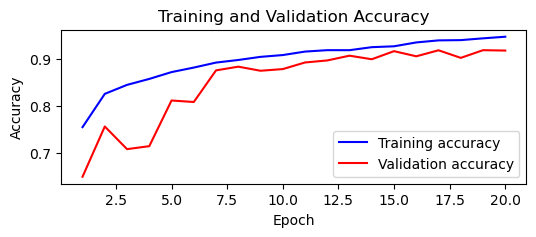

In [14]:
# Plot for checking training and validation accuracy through training.
plt.figure(figsize=(6, 2))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# model.save('custom_unet.h5')

In [7]:
"""
Blur around human:
The function loads the model, then preprocesses the image in the correct dimensions that the neural network is compatible with. The model predicts the mask and then resizes the mask for the original image resolution.
It inverts the mask capturing the surroundings of the human. Uses OpenCV to apply a blurred effect on the inverted mask area then replicate the mask across three channels to make it compatible with rgb.

"""
def predict_blur_mask(image_path, model_path):
    model = load_model('custom_unet.h5')

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_resized = cv2.resize(image, (256, 256)) / 255.0
    image_expanded = np.expand_dims(image_resized, axis=0)

    predicted_mask = model.predict(image_expanded)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    mask_resized = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))

    inverted_mask = 1 - mask_resized

    blurred_background = cv2.GaussianBlur(image, (31, 31), 0)

    inverted_mask_3ch = np.stack((inverted_mask,)*3, axis=-1)

    segmented_image = np.where(inverted_mask_3ch == 1, blurred_background, image)

    return segmented_image

"""
Human segmentation:
The function loads the model, then preprocesses the image in the correct dimensions that the neural network is compatible with. The model predicts the mask and then resizes the mask for the original image resolution.
The mask is then replicated across three channels to make it compatible with rgb.

"""
def predict_human_segmentation(image_path, model_path):
    
    model = load_model('custom_unet.h5')

    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_resized = cv2.resize(image, (256, 256)) / 255.0
    image_expanded = np.expand_dims(image_resized, axis=0)

    predicted_mask = model.predict(image_expanded)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    mask_resized = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    mask_colored = np.stack((mask_resized,)*3, axis=-1) * 255
    segmented_image = cv2.addWeighted(image, 1, mask_colored, 0.5, 0)

    return segmented_image

In [8]:
segmented_image = predict_human_segmentation('data\\testimg\\human1.jpg', 'custom_unet.h5')

# Calculating the scaling factor for showcasing the image in OpenCV.
scaling_factor = 0.2

# Getting the original dimensions.
original_height, original_width = segmented_image.shape[:2]

# Calculating the new dimensions.
new_width = int(original_width * scaling_factor)
new_height = int(original_height * scaling_factor)

resized_image = cv2.resize(segmented_image, (new_width, new_height))

# OpenCV display.
cv2.imshow('Segmented Image', resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 1s 585ms/step
